In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import join as op_join
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from tqdm import tqdm

from ls_ood_detect_cea import log_evaluate_lared_larem, apply_pca_ds_split, \
    apply_pca_transform, save_roc_ood_detector, select_and_log_best_lared_larem

In [2]:
entropy_samples_folder = "./entropy/"
ind_dataset_name = "woodscapes"
ood_datasets = ["woodscapes_anomal", "woodscapes_soil"]

n_pca_components = [4, 8, 16, 32, 40, 48, 56, 64, 128, 256]
hook_layer_type = "Dropblock"

# Load precalculated entropies

Entropies were calculated and saved in the previous notebook: [Notebook 1: extract MCDz samples](https://git.irt-systemx.fr/confianceai/ec_3/n6_monitoring/component-latent-space/ood-latent-space/-/blob/4-finish-library/examples/1_example_deeplab_segmentation_samples_extraction.ipynb?ref_type=heads)

In [3]:
# Load InD entropies
ind_data_dict = {
    "h_z_train": np.load(file=op_join(entropy_samples_folder, f"{ind_dataset_name}_h_z_train.npy")),
    "h_z": np.concatenate(
        (
            np.load(file=op_join(entropy_samples_folder, f"{ind_dataset_name}_h_z_test.npy")),
            np.load(file=op_join(entropy_samples_folder, f"{ind_dataset_name}_h_z_valid.npy"))
        )
    )
}

# OoD Entropies
ood_entropies_dict = {}
for ood_dataset in ood_datasets:
    ood_entropies_dict[ood_dataset] = np.concatenate(
        (
            np.load(file=op_join(entropy_samples_folder, f"{ood_dataset}_h_z_test.npy")),
            np.load(file=op_join(entropy_samples_folder, f"{ood_dataset}_h_z_valid.npy"))
        )
    )

In [4]:
# Let's check the datasets sizes
print(ind_data_dict['h_z'].shape)
print(ind_data_dict['h_z_train'].shape)
print(ood_entropies_dict.keys())
print(ood_entropies_dict[ood_datasets[0]].shape)
print(ood_entropies_dict[ood_datasets[1]].shape)

(2305, 2048)
(5929, 2048)
dict_keys(['woodscapes_anomal', 'woodscapes_soil'])
(2305, 2048)
(1800, 2048)


# Evaluate LaREx performance

Let's evaluate LaREx while reducing dimensionality of samples with PCA, with the already defined number of components

In [5]:
# Initialize df to store all the results
overall_metrics_df = pd.DataFrame(columns=['auroc', 'fpr@95', 'aupr',
                                           'fpr', 'tpr', 'roc_thresholds',
                                           'precision', 'recall', 'pr_thresholds'])

# Perform evaluation with PCA reduced vectors
for n_components in tqdm(n_pca_components, desc="Evaluating PCA"):
    # Perform PCA dimension reduction
    pca_h_z_ind_train, pca_transformation = apply_pca_ds_split(
        samples=ind_data_dict["h_z_train"],
        nro_components=n_components
    )
    pca_h_z_ind_test = apply_pca_transform(ind_data_dict["h_z"], pca_transformation)
    ood_pca_dict = {}
    for ood_dataset in ood_datasets:
        ood_pca_dict[ood_dataset] = apply_pca_transform(ood_entropies_dict[ood_dataset], pca_transformation)

    r_df = log_evaluate_lared_larem(
        ind_train_h_z=pca_h_z_ind_train,
        ind_test_h_z=pca_h_z_ind_test,
        ood_h_z_dict=ood_pca_dict,
        experiment_name_extension=f" PCA {n_components}",
        return_density_scores=False,
        log_step=n_components,
        mlflow_logging=False
    )
    # Add results to df
    overall_metrics_df = overall_metrics_df.append(r_df)

Evaluating PCA: 100%|██████████| 10/10 [02:07<00:00, 12.79s/it]


# Visualize results

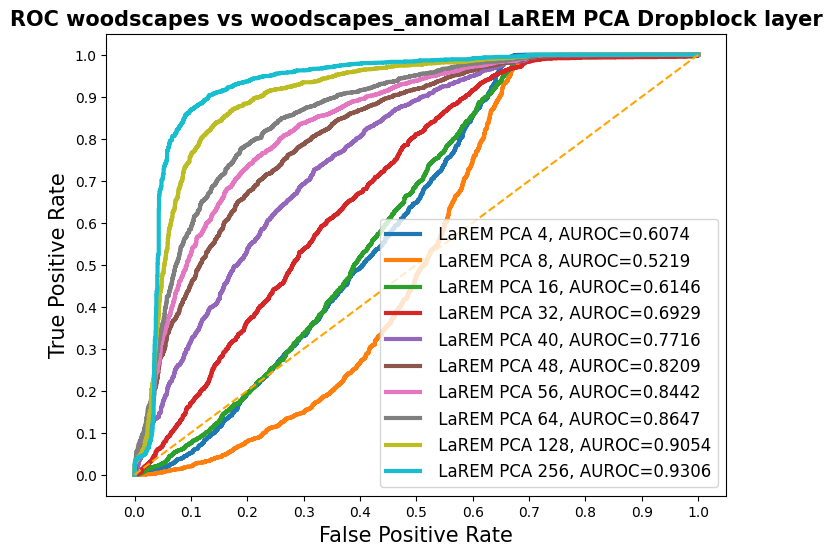

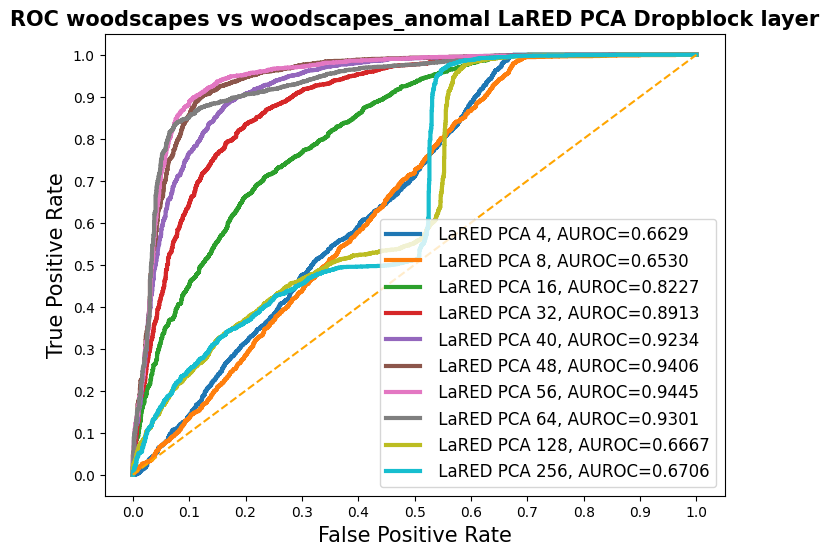

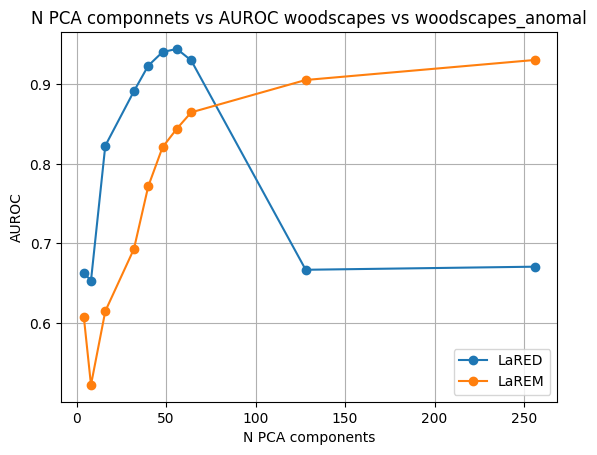

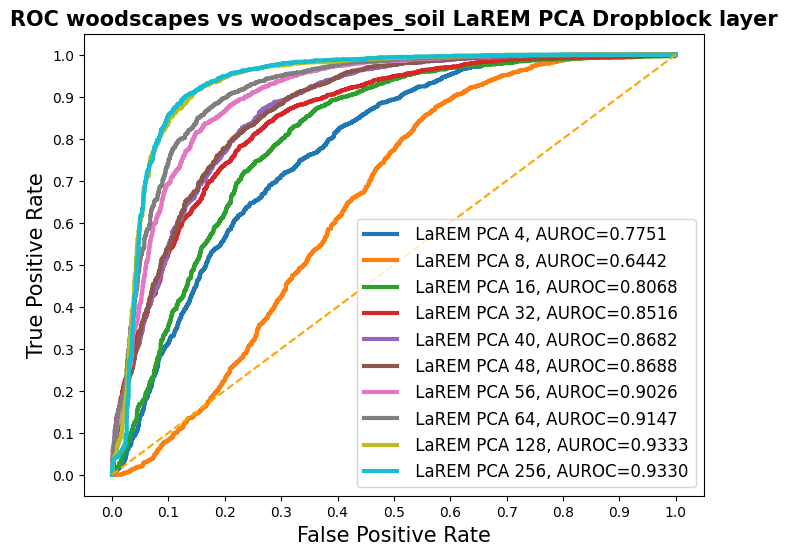

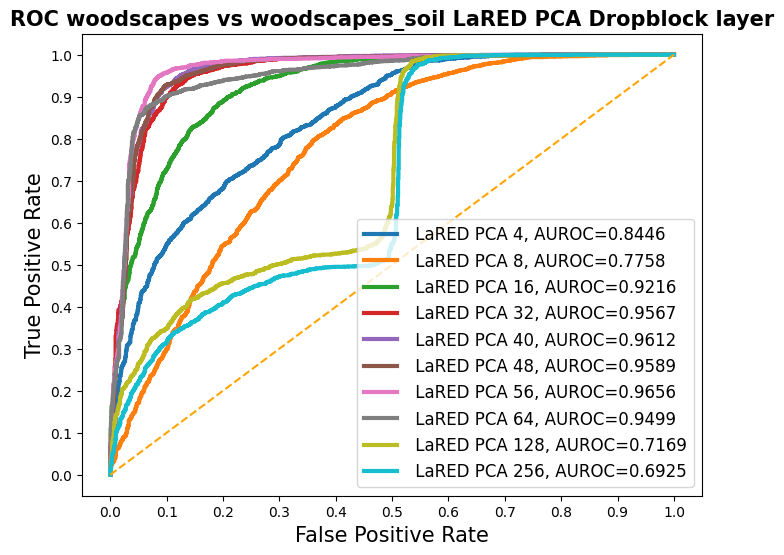

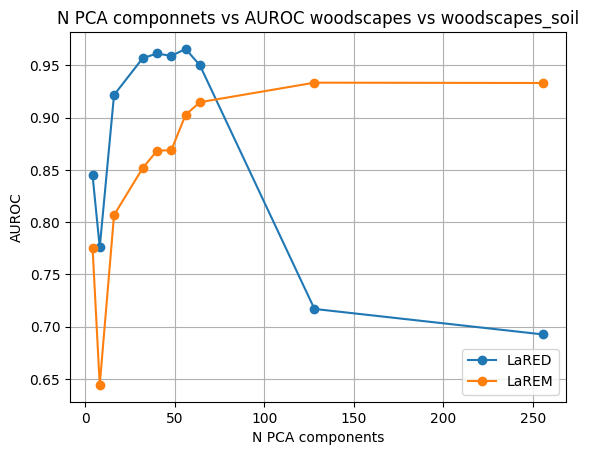

In [6]:
# Plot Roc curves together, by OoD dataset
for ood_dataset in ood_datasets:
    temp_df_pca_lared = pd.DataFrame(columns=['auroc', 'fpr@95', 'aupr',
                                              'fpr', 'tpr', 'roc_thresholds',
                                              'precision', 'recall', 'pr_thresholds'])
    temp_df_pca_larem = pd.DataFrame(columns=['auroc', 'fpr@95', 'aupr',
                                              'fpr', 'tpr', 'roc_thresholds',
                                              'precision', 'recall', 'pr_thresholds'])
    for row_name in overall_metrics_df.index:
        if ood_dataset in row_name and "PCA" in row_name and "LaREM" in row_name:
            temp_df_pca_larem = temp_df_pca_larem.append(overall_metrics_df.loc[row_name])
            temp_df_pca_larem.rename(index={row_name: row_name.split(ood_dataset)[1]}, inplace=True)
        elif ood_dataset in row_name and "PCA" in row_name and "LaRED" in row_name:
            temp_df_pca_lared = temp_df_pca_lared.append(overall_metrics_df.loc[row_name])
            temp_df_pca_lared.rename(index={row_name: row_name.split(ood_dataset)[1]}, inplace=True)
    # Plot ROC curves
    roc_curve_pca_larem = save_roc_ood_detector(
        results_table=temp_df_pca_larem,
        plot_title=f"ROC {ind_dataset_name} vs {ood_dataset} LaREM PCA {hook_layer_type} layer"
    )
    
    roc_curve_pca_lared = save_roc_ood_detector(
        results_table=temp_df_pca_lared,
        plot_title=f"ROC {ind_dataset_name} vs {ood_dataset} LaRED PCA {hook_layer_type} layer"
    )
    plt.show()
    
    plt.plot(n_pca_components, temp_df_pca_lared["auroc"], marker="o", label="LaRED")
    plt.plot(n_pca_components, temp_df_pca_larem["auroc"], marker="o", label="LaREM")
    plt.legend()
    plt.grid()
    plt.xlabel("N PCA components")
    plt.ylabel("AUROC")
    plt.title(f"N PCA componnets vs AUROC {ind_dataset_name} vs {ood_dataset}")

In [10]:
best_auroc_lared, best_aupr_lared, best_fpr_lared, best_n_components_lared = select_and_log_best_lared_larem(
    overall_metrics_df,
    n_pca_components,
    "LaRED",
    log_mlflow=False
)
print("Best AUROC LARED: ", best_auroc_lared)
print("Best AUPR LARED: ", best_aupr_lared)
print("Best FPR@95 LARED: ", best_fpr_lared)
print("Best N PCA components LARED: ", best_n_components_lared)

Best AUROC LARED:  0.9550514817237854
Best AUPR LARED:  0.9431001543998718
Best FPR@95 LARED:  0.13601891696453094
Best N PCA components LARED:  56


In [11]:
best_auroc_larem, best_aupr_larem, best_fpr_larem, best_n_components_larem = select_and_log_best_lared_larem(
    overall_metrics_df,
    n_pca_components,
    "LaREM",
    log_mlflow=False
)
print("Best AUROC LAREM: ", best_auroc_larem)
print("Best AUPR LAREM: ", best_aupr_larem)
print("Best FPR@95 LAREM: ", best_fpr_larem)
print("Best N PCA components LAREM: ", best_n_components_larem)

Best AUROC LAREM:  0.9318009912967682
Best AUPR LAREM:  0.8947661221027374
Best FPR@95 LAREM:  0.22196191549301147
Best N PCA components LAREM:  256


It is possible to observe that the best LaRED performances are achieved for those performed with 56 PCA components, whereas for LaREM, the best results are better when having more PCA components.

For this example, LaRED performed better than LaREM overall